In [1]:
pip install keras_efficientnets

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install efficientnet

     |████████████████████████████████| 50 kB 1.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install Keras-Applications

Note: you may need to restart the kernel to use updated packages.


In [27]:
from keras import applications
from keras import callbacks
import pandas as pd
import numpy as np
import glob
import os
import keras
from keras.layers import Input, Dense, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as efn
from keras.models import Sequential

In [7]:
train_path = '/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training'
test_path = '/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test'

In [8]:
train_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training/*/*.jpg')
test_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test/*/*.jpg')

print("Total number of training images: ", len(train_image_names))
print("Total number of training images: ", len(test_image_names))

Total number of training images:  39375
Total number of training images:  8617


In [9]:
NUM_CLASSES = len(next(os.walk(train_path))[1])

print("Number of classes: {}".format(NUM_CLASSES))

Number of classes: 2


In [10]:
train_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training/*/*.jpg')
train_Fire_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training/Fire/*.jpg')
train_noFire_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training/No_Fire/*.jpg')

print("Total number of training images: ", len(train_image_names))
print("number of Fire images: ", len(train_Fire_image_names))
print("number of No Fire images: ", len(train_noFire_image_names))

Total number of training images:  39375
number of Fire images:  25018
number of No Fire images:  14357


In [11]:
test_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test/*/*.jpg')
test_Fire_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test/Fire/*.jpg')
test_noFire_image_names = glob.glob('/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test/No_Fire/*.jpg')

print("Total number of training images: ", len(test_image_names))
print("number of Fire images: ", len(test_Fire_image_names))
print("number of No Fire images: ", len(test_noFire_image_names))

Total number of training images:  8617
number of Fire images:  5137
number of No Fire images:  3480


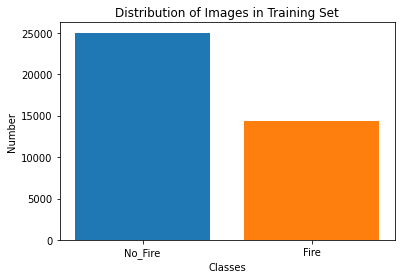

In [12]:
plt.bar(os.listdir('/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training')[0], len(train_Fire_image_names))
plt.bar(os.listdir('/kaggle/input/firevsnofire/Fire-vs-NoFire/Training/Training/')[1], len(train_noFire_image_names))
plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Distribution of Images in Training Set")
plt.show()

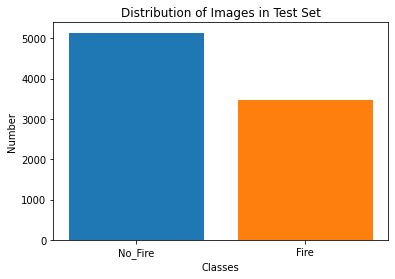

In [13]:
plt.bar(os.listdir('/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test')[0], len(test_Fire_image_names))
plt.bar(os.listdir('/kaggle/input/firevsnofire/Fire-vs-NoFire/Test/Test')[1], len(test_noFire_image_names))
plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Distribution of Images in Test Set")
plt.show()

In [15]:
IMG_WIDTH, IMG_HEIGHT = 224,224
channels = 3
BATCH_SIZE = 32

input_shape = (IMG_HEIGHT, IMG_WIDTH, channels)

In [19]:
# ImageDataGenerator for training pictures with data augmentation
eff_train_datagen = ImageDataGenerator (
            preprocessing_function=preprocess_input,
            rescale=1./255,
            horizontal_flip = True, 
            validation_split = 0.2, # Split into Train/Validation
            featurewise_center = False,  # set input mean to 0 over the dataset
            samplewise_center = False,  # set each sample mean to 0
            featurewise_std_normalization = False,  # divide inputs by std of the dataset
            samplewise_std_normalization = False,  # divide each input by its std
            zca_whitening = False,  # apply ZCA whitening
            rotation_range = 40,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range = 0.2,  # randomly shift images vertically (fraction of total height)
            vertical_flip = False,  # randomly flip images
            shear_range=0.2,
            fill_mode='nearest',)

In [20]:
eff_train_generator = eff_train_datagen.flow_from_directory(
                                                            train_path,
                                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                            subset="training",
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            classes = ('Fire','No_Fire')
                                                            )

eff_validation_generator = eff_train_datagen.flow_from_directory(
                                                            train_path,
                                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                            subset="validation",
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            classes = ('Fire','No_Fire')
                                                        )

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


{'Fire': 0, 'No_Fire': 1}
{'Fire': 0, 'No_Fire': 1}


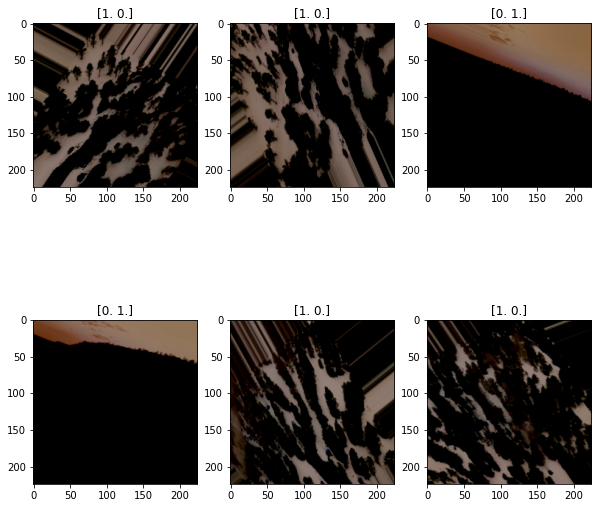

In [21]:
# Plot the random images
fig , axs = plt.subplots(2,3 ,figsize = (10,10))
axs[0][0].imshow(eff_train_generator[0][0][12])
axs[0][0].set_title(eff_train_generator[0][1][12])
axs[0][1].imshow(eff_train_generator[0][0][1])
axs[0][1].set_title(eff_train_generator[0][1][1])
axs[0][2].imshow(eff_train_generator[0][0][14])
axs[0][2].set_title(eff_train_generator[0][1][14])
axs[1][0].imshow(eff_train_generator[0][0][17])
axs[1][0].set_title(eff_train_generator[0][1][17])
axs[1][1].imshow(eff_train_generator[0][0][19])
axs[1][1].set_title(eff_train_generator[0][1][19])
axs[1][2].imshow(eff_train_generator[0][0][3])
axs[1][2].set_title(eff_train_generator[0][1][3])

#Title of 0.0 refers to Fire
#1.0 refers to NoFire
print(eff_train_generator.class_indices)
print(eff_validation_generator.class_indices)

In [28]:
# EfficientNet Model Summary
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=2)

effmodel = Sequential()
effmodel.add(efnb0)
effmodel.add(GlobalAveragePooling2D())
effmodel.add(Dropout(0.5))
effmodel.add(Dense(2, activation='softmax'))
effmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [29]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

In [30]:
# Compilation of model
effmodel.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['binary_accuracy']
)

In [31]:
eff_train_steps = eff_train_generator.n // eff_train_generator.batch_size
eff_valid_steps = eff_validation_generator.n // eff_validation_generator.batch_size

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=valid_steps,
        verbose=1,
        callbacks=[checkpointer]
       )

In [32]:
# Fit data to model
eff_history = effmodel.fit_generator(
                            eff_train_generator,
                            steps_per_epoch=eff_train_steps,
                            epochs = 10,
                            validation_data = eff_validation_generator,
                            validation_steps=eff_valid_steps,
                            verbose=1,
                            callbacks=[early_stop, rlrop]
                )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
984/984 [==============================] - 838s 839ms/step - loss: 0.0585 - binary_accuracy: 0.9806 - val_loss: 0.0280 - val_binary_accuracy: 0.9874
Epoch 2/10
984/984 [==============================] - 588s 598ms/step - loss: 0.0227 - binary_accuracy: 0.9920 - val_loss: 0.0214 - val_binary_accuracy: 0.9931
Epoch 3/10
984/984 [==============================] - 598s 608ms/step - loss: 0.0193 - binary_accuracy: 0.9929 - val_loss: 0.1127 - val_binary_accuracy: 0.9602
Epoch 4/10
984/984 [==============================] - 601s 611ms/step - loss: 0.0140 - binary_accuracy: 0.9953 - val_loss: 0.0802 - val_binary_accuracy: 0.9741
Epoch 5/10
984/984 [==============================] - 605s 614ms/step - loss: 0.0164 - binary_accuracy: 0.9948 - val_loss: 0.1192 - val_binary_accuracy: 0.9724
Epoch 6/10
984/984 [==============================] - 592s 601ms/step - loss: 0.0170 - binary_accuracy: 0.9942 - val_loss: 0.0415 - val_binary_accuracy: 0.9854
Epoch 7/10
984/984 [====================

In [33]:
#saving the trained model weights as data file in .h5 format
effmodel.save_weights("efficientnetb0_weights.h5")

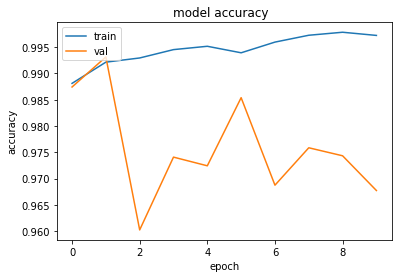

In [34]:
# summarize history for accuracy
plt.plot(eff_history.history['binary_accuracy'] )
plt.plot(eff_history.history['val_binary_accuracy'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

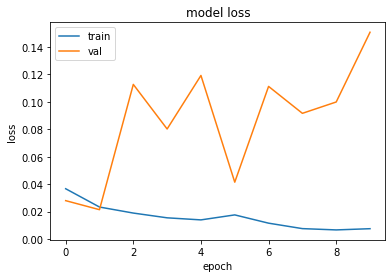

In [35]:
# summarize history for loss
plt.plot(eff_history.history['loss'] )
plt.plot(eff_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
# Training Accuracy
train_score = effmodel.evaluate_generator(generator = eff_train_generator, verbose = 1)
print("Train accuracy : {:.2f} %".format(train_score[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


985/985 [==============================] - 434s 441ms/step - loss: 0.0061 - binary_accuracy: 0.9973
Train accuracy : 99.73 %


In [37]:
# Validation Accuracy
valid_loss, valid_accuracy = effmodel.evaluate_generator(generator = eff_validation_generator, verbose = 1)
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

247/247 [==============================] - 107s 434ms/step - loss: 0.1516 - binary_accuracy: 0.9651
Validation Accuracy:  96.51 %


In [38]:
# Using Test Data
eff_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
                                  rescale=1/255,
                                    validation_split=0.10,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
)

eff_test_generator = eff_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes = ('Fire','No_Fire')
)

Found 8617 images belonging to 2 classes.


In [39]:
# Test Accuracy
test_score = effmodel.evaluate_generator(generator = eff_test_generator,verbose=1)
print("Test accuracy : {:.2f} %".format(test_score[1]*100))

270/270 [==============================] - 163s 606ms/step - loss: 0.8645 - binary_accuracy: 0.7619
Test accuracy : 76.19 %


In [40]:
eff_test_steps = eff_test_generator.n // eff_test_generator.batch_size

In [41]:
# Evaluation of the model
effpreds = effmodel.predict_generator(
    generator = eff_test_generator,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


270/270 [==============================] - 111s 406ms/step


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
from sklearn.metrics import confusion_matrix

test_labels = eff_test_generator.classes
cm = confusion_matrix(test_labels, effpreds.argmax(axis=1))

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Confusion matrix, without normalization
[[3694 1443]
 [ 613 2867]]


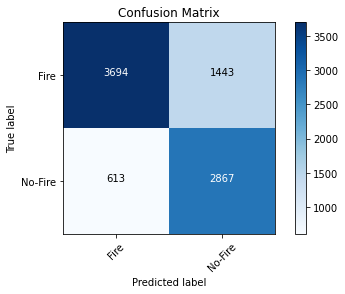

In [48]:
import itertools
cm_plot_labels = ['Fire','No-Fire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')